## CdTe-Tellurene FANTASTX search analysis

We use the output files from a FANTAStX search and checkout the solutions

In [2]:
# imports

import numpy as np
from matplotlib import pyplot as plt
import os, shutil
import cv2

from fx19.fingerprinting import Comparator  
from fx19 import structure_record
from pymatgen.core.structure import Structure

from scripts.analysis import *
from scripts.dfp_obj_fn import plot_dfp_Pareto

First, checkout the `data_file`

which contains the important information regarding each candidate from the search

the candidate `label`, its `total energy`, multiple objective function values and also its `inheritance`

In [7]:
# Read the data file and plot all data
data_file_path = "completed_run/data_file"
cdte_tellurene_results = read_in_data_file(data_file_path, "multi")

all_labels = list(cdte_tellurene_results.keys())
all_obj0s = [cdte_tellurene_results[label][1] for label in all_labels]
all_obj1s = [cdte_tellurene_results[label][2] for label in all_labels]

print ('Total evaluated models: ', len(all_labels))

Total evaluated models:  210


Now, plot the objective function values of all candidates and obtain the Pareto front.

- A convex hull is constructed using the Pareto Points

- The perpendicular distance of each data point from the Pareto convex hull is used as its overall value

- The selection probability for a candidate depends on its overall value (which we typically minimize)

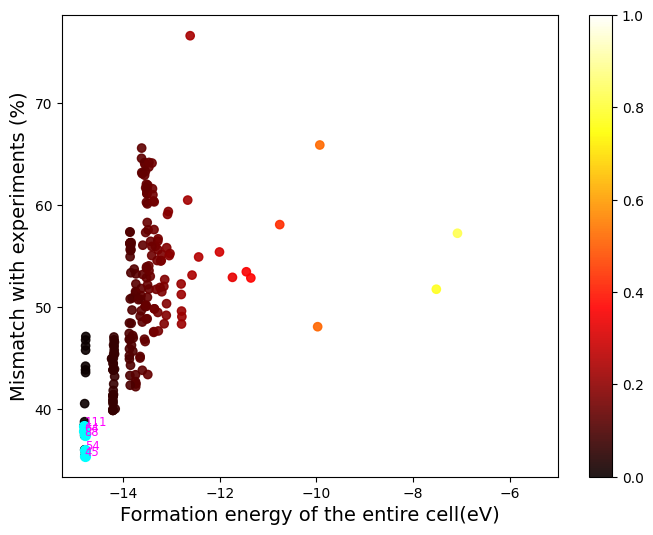

In [8]:
plot_dfp_Pareto(all_labels, all_obj0s, all_obj1s)

- We can see that there are several points overlapping with each other. This suggests that there may be some candidates that are repeated. 

- Even though unrelaxed structures are different, they may still belong to same local basin, and relax to same local minima. We need to find these candidates and eliminate them from our data.

- For this, first, initialize the fingerprinting Comparator

In [9]:
# Create a fingerprinting Comparator object and remove the duplicates

# variables to be given as input
fp_label = 'bag-of-bonds'                   # fingerprinting mode
fp_tolerances = {fp_label: [0.03, 0.7]}     # tolerances for the fingerprinting mode
z_bounds = [15.91 , 27.09]

comparator = Comparator(label=fp_label, tolerances=fp_tolerances)
comparator.zbounds = z_bounds

- Make sure, that all the candidates are sorted in a non-dominated manner

In [10]:
# First, sort the data in a non-dominated manner
combined_data = list(zip(all_labels, all_obj0s, all_obj1s))
sorted_data = sorted(combined_data, key=lambda x: (x[1], x[2]))
all_labels, all_obj0s, all_obj1s = zip(*sorted_data)

- Create all the unique labels 

- Keep the ones that are lowest in energy and mismatch in case there are duplicates found

In [12]:
all_poscars = [f'POSCAR_relaxed_{label}' for label in all_labels]
reg_id = structure_record.register_id()

models = []
for label, pos in zip(all_labels, all_poscars):
    astr = Structure.from_file(f'completed_run/calcs/{pos}')
    model = structure_record.model(astr, reg_id)
    model.label = label
    models.append(model)
    
uniq_models = []
for i, model in enumerate(models):
    comparator.create_fingerprint(model)
    if i == 0:
        uniq_models.append(model)
        continue
    uniq = comparator.check_model_uniqueness(model, uniq_models)
    if uniq:
        uniq_models.append(model)

In [13]:
uniq_labels = [model.label for model in uniq_models]
uniq_data = {k:v for k, v in cdte_tellurene_results.items() if k in uniq_labels}
uniq_obj0s = [uniq_data[k][1] for k in uniq_labels]
uniq_obj1s = [uniq_data[k][2] for k in uniq_labels]

print ('Total unique models: ', len(uniq_labels))

Total unique models:  74


- Get the Pareto points and plot the Pareto convex hull with the unique models

In [15]:
plot_dfp_Pareto(uniq_labels, uniq_obj0s, uniq_obj1s)

NameError: name 'QhullError' is not defined

After removing the duplicates, the Pareto construction throws an error..

- So, just plot all the uniq models data and visualize

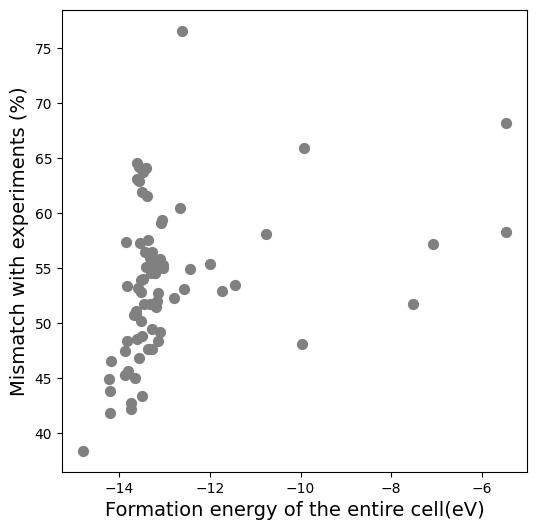

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(uniq_obj0s, uniq_obj1s, c='gray', s=50)
plt.xlabel('Formation energy of the entire cell(eV)', fontsize=14)
plt.ylabel('Mismatch with experiments (%)', fontsize=14)
plt.show()

As we can see there is only one points that are non-dominated. We need more than 3 non-dominated solutions to contruct a Pareto front.

For this specific problem, there is only one solution that is minmum along both the formation energy and the experimental mismatch. 

Let us check this solution ...

In [17]:
low_obj0_label = uniq_labels[np.argmin(uniq_obj0s)]
low_obj1_label = uniq_labels[np.argmin(uniq_obj1s)]

print ('Lowest obj0: ', low_obj0_label)
print ('Lowest obj1: ', low_obj1_label)

Lowest obj0:  111
Lowest obj1:  111


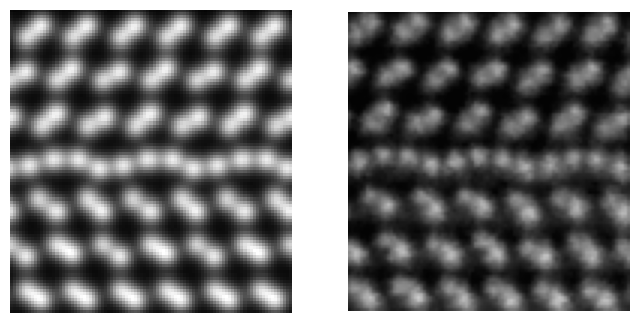

In [18]:
im_data = cv2.imread('completed_run/calcs/gb_im_model_111.jpg')
exp_data = np.load('images/tellurene_sliced.npy').astype('float64')

f, axes = plt.subplots(1, 2, figsize=(8, 5))
axes[0].imshow(im_data, cmap='gray'); axes[0].axis('off')
axes[1].imshow(exp_data, cmap='gray'); axes[1].axis('off'); plt.show()

![Image alt text](completed_run/vesta_111.png)